# Women's voices before and after #MeToo

## Introduction
In this project, we will use the [Quotebank dataset](#https://dl.acm.org/doi/pdf/10.1145/3437963.3441760), an open corpus of 178 million quotations attributed to the speakers who uttered them, extracted from 162 million English news articles published between 2008 and 2020. We will here restrict our analysis to articles published between 2015 and 2020.


## Preprocessing
We are provided with one dataset per year, which are pretty large (from 792,3Mo to 4,84Go). The datasets provided to us follow the pattern below: 

```
root
 |-- quoteID: string 
 |-- quotation: string 
 |-- speaker: string 
 |-- qids: list
 |-- date: string 
 |-- numOccurrences: int
 |-- probas: list
 |-- urls: list
 |-- phase: string 
```

1. Since our analysis will be based on the difference between male and female speakers, we need to keep only the quotations for which the speakers are known. We therefore dropped the quotations for which the speaker is unknown, and made the choice to keep only the quotations for which the probability that it is the correct speaker is greater than 0.7.


2. To further reduce the datasets, we removed columns of no interest to our analysis: urls, probas, phase and quoteID. We splitted the dataset of 2017 in two: January-October (date of the emergence of the movement) and October-December. After that, we removed the date, still only knowing the year of the dataset will be enough for our analysis. Steps 1 and 2 were performed using Google colab. 
The code for these two first steps is available [here](src/Reduce_data.ipynb).


3. Next, in order to have useful information about the speakers, we used additional speaker metadata available for ~9M unique Wikidata entities (identified by their QID) in the form of a .parquet file named speaker_attributes.parquet. We removed from the original datasets all the quotations for which multiple QIDS are linked: indeed, we cannot now which of the homonyms is the real speaker. Then we merged our dataset with the attributes of the speakers, and we decided to keep the following attributes: 'gender', 'date_of_birth', 'occupation', 'id', 'ethnic_group', 'academic_degree', 'occupation' and 'religion'. For each dataset, we computed the age of the speaker the year of the quotation, and thus transformed the column 'date_of_birth' by a column 'age'. Thus, after merging, the datasets follow the following pattern:
```
root
 |-- quotation: string 
 |-- speaker: string 
 |-- qids: list
 |-- numOccurrences: int
 |-- gender: ndarray
 |-- age: int
 |-- occupation: ndarray
 |-- ethnic_group: ndarray
 |-- academic_degree: ndarray
 |-- religion: ndarray
```


4. Then, we dropped the quotations for which the gender is not known, since we will build all our analyses on it. We then replaced all the wikicodes in the dataset with readable information, using a [dictionnary](data/wikidata_labels_descriptions_quotebank.csv.bz2) linking wikidata labels and descriptions. The speakers for which the year of birth is not known are also removed. 


5. The data sets are now reduced. To perform the following primary descriptive tasks, we used only samples from these reduced data sets. For each year, we considered a sample of 100,000 quotations per year for all years except 2017, for which we have a total of 200'000 quotations (100'000 before #MeToo and 100'000 after). The data are stored under .json.bz2 files and are named "sample-{year}".


6. We already prepared our datasets for the observational study that we will do in Milestone 3. We filtered again the data, by removing all the rows containing a None for one of the attributes (occupation, ethnic_group, academic_degree, religion). It was already done for the age, gender and speaker. Indeed, in order to calculate the propensity scores, we will need to know all of them. The data are stored under .json.bz2 files and are named "filtered-{year}". The code is available [here](src/get_attributes.ipynb).

The code for step 3, 4, 5 and 6 is available [here](src/get_attributes.ipynb).



## Imports

In [1]:
import pandas as pd
import bz2
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from utils import quotes_by_gender, unique_speaker_per_gender, get_champlex
from collections import Counter
import math

## Datasets

In [2]:
DATA_FOLDER = 'data/'


DATA_2015 = DATA_FOLDER+"sample-2015.json.bz2"
DATA_2016 = DATA_FOLDER+"sample-2016.json.bz2"
DATA_2017_BEFORE = DATA_FOLDER + "sample-2017-before.json.bz2"
DATA_2017_AFTER = DATA_FOLDER + "sample-2017-after.json.bz2"
DATA_2018 = DATA_FOLDER+"sample-2018.json.bz2"
DATA_2019 = DATA_FOLDER+"sample-2019.json.bz2"
DATA_2020 = DATA_FOLDER+"sample-2020.json.bz2"


## Wikidata attributes and dictionnary

In [3]:
WIKIDATA_LABELS = DATA_FOLDER + "wikidata_labels_descriptions_quotebank.csv.bz2"
SPEAKER_ATTRIBUTES_DATA = DATA_FOLDER+"speaker_attributes.parquet"

Load the data:

In [4]:
wiki_labels = pd.read_csv(WIKIDATA_LABELS, compression='bz2', index_col='QID')

In [5]:
quotes_2015 = pd.read_json(DATA_2015)
quotes_2016 = pd.read_json(DATA_2016)
quotes_2017_before = pd.read_json(DATA_2017_BEFORE)
quotes_2017_after = pd.read_json(DATA_2017_AFTER)
quotes_2018 = pd.read_json(DATA_2018)
quotes_2019 = pd.read_json(DATA_2019)
quotes_2020 = pd.read_json(DATA_2020)

In [6]:
quotes_2017 = pd.concat([quotes_2017_before, quotes_2017_after])

In [7]:
years = [2015, 2016, 2017, 2018, 2019, 2020]
quotes_years = [quotes_2015, quotes_2016, quotes_2017, quotes_2018, quotes_2019, quotes_2020]

In [8]:
years_detailed = [2015, 2016, 2017, 2017, 2018, 2019, 2020]
period_detailed = ['Before #MeToo', 'Before #MeToo', 'Before #MeToo',
                   'After #MeToo (short term)', 'After #MeToo (short term)', 
                   'After #MeToo (long term)','After #MeToo (long term)']
quotes_years_detailed= [quotes_2015, quotes_2016, quotes_2017_before, quotes_2017_after, 
                        quotes_2018, quotes_2019, quotes_2020]

In [9]:
for i in range(len(quotes_years_detailed)):
    quotes_years_detailed[i]['year']=years_detailed[i]
    quotes_years_detailed[i]['period']=period_detailed[i]

In [10]:
quotes_all = pd.concat(quotes_years_detailed, ignore_index=True)

In [11]:
quotes_before = pd.concat([quotes_2015, quotes_2016, quotes_2017_before], ignore_index=True)
quotes_after_shortterm = pd.concat([quotes_2017_after, quotes_2018], ignore_index=True)
quotes_after_longterm = pd.concat([quotes_2019, quotes_2020], ignore_index=True)
quotes_after = pd.concat([quotes_after_shortterm, quotes_after_longterm], ignore_index=True)

In [12]:
periods = ['Before #MeToo', 'After #MeToo (short term)', 'After #MeToo (long term)']
quotes_periods = [quotes_before, quotes_after_shortterm, quotes_after_longterm]

In [13]:
quotes_before.head()

,quotation,speaker,qids,numOccurrences,gender,age,occupation,ethnic_group,academic_degree,religion,year,period
0,"Once you're at Triple-A, you're an injury away...",Theo Epstein,Q1057736,1,male,42,"[executive, president, businessperson]",None,None,None,2015,Before #MeToo
1,This enhances the interaction between the ligh...,David Hunger,Q42419043,1,male,38,[researcher],None,None,None,2015,Before #MeToo
2,These events certainly do help Hong Kong to ma...,Allan Zeman,Q2837795,1,male,66,"[fashion designer, justice of the peace, busin...",None,None,None,2015,Before #MeToo
3,One of the joys of living in Corpus Christi is...,Craig Henderson,Q1138558,1,male,28,[association football player],None,None,None,2015,Before #MeToo
4,"We must deduct points, relegate a team [ to a ...",Sepp Blatter,Q483437,33,male,79,"[sports official, economist, politician, ice h...",[Swiss],None,None,2015,Before #MeToo


# Gender representations in the news
## Number of quotations by gender from 2015 to 2020

In [14]:
by_gender_years = []
for year, quotes in zip(years, quotes_years):
    by_gender_years.append(quotes_by_gender(quotes, year, major_only = False, others_grouped = True))

quotes_by_gender_years = pd.concat(by_gender_years, ignore_index = True)

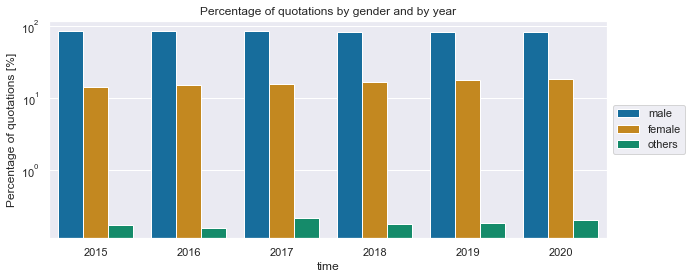

In [15]:
sns.set(rc = {'figure.figsize':(10,4)})
sns.set_palette('colorblind')

ax = sns.barplot(x = quotes_by_gender_years['time'], y = quotes_by_gender_years['count']*100, hue = quotes_by_gender_years['gender'], data = quotes_by_gender_years)
ax.set(yscale="log");
ax.set(ylabel='Percentage of quotations [%]')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Percentage of quotations by gender and by year');

**Be careful, this plot has log scale in y-axis.**

By plotting the percentage of quotes by gender for every year from 2015 to 2020, we clearly see that the 'male' gender is the most represented and is the one for which most of the quotes are related.
We can also see the proportion of speakers having a different gender than 'male' or 'female' is really low. For this reason, and since our analysis will mainly focus of the 'female' gender and its differences with the 'male' gender, we will discard these speakers for further analysis.

In [16]:
#Drop the rows having a gender other than the 2 most represented 
for year, quotes in zip(years, quotes_years):
    quotes.drop(quotes[
        quotes['gender'].isin(quotes_by_gender(quotes, major_only = True)['gender']) == False].index, inplace = True)

In [17]:
for period, quotes in zip(periods, quotes_periods):
    quotes.drop(quotes[
        quotes['gender'].isin(quotes_by_gender(quotes, major_only = True)['gender']) == False].index, inplace = True)

Let's look at the percentage of quotations by gender for every year, now that we have only 'male' and 'female' genders.

In [18]:
by_gender_years = []
for year, quotes in zip(years, quotes_years):
    by_gender_years.append(quotes_by_gender(quotes, year, major_only = True))

quotes_by_gender_years = pd.concat(by_gender_years, ignore_index = True)

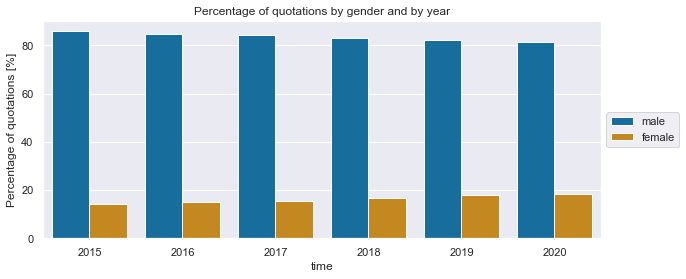

In [19]:
sns.set(rc = {'figure.figsize':(10,4)})
sns.set_palette('colorblind')

ax = sns.barplot(x = quotes_by_gender_years['time'], 
                 y = quotes_by_gender_years['count']*100, hue = quotes_by_gender_years['gender'], 
                 data = quotes_by_gender_years)
ax.set(ylabel='Percentage of quotations [%]')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Percentage of quotations by gender and by year');

Looking at this graph, we see a clear difference between the percentage of male and female quotations. In fact, about 80% of all reported quotations are by men. However, looking at the women, we can see a slight increase in their percentage of quotations over time.

Let's now take a closer look at the impact of the #MeToo movement by separating time into 3 categories:

-before #MeToo: January 2015 to October 2017.

-After #MeToo (short term): from October 2017 to December 2018

-after #MeToo (long term): from January 2019 to December 2020.


In [20]:
by_gender_periods = []
for period, quotes in zip(periods, quotes_periods):
    by_gender_periods.append(quotes_by_gender(quotes, period, major_only = True))

quotes_by_gender_periods = pd.concat(by_gender_periods, ignore_index = True)

In [21]:
quotes_by_gender_periods

,gender,count,Occurrences,time
0,male,0.850526,0.847414,Before #MeToo
1,female,0.149474,0.152586,Before #MeToo
2,male,0.838579,0.839697,After #MeToo (short term)
3,female,0.161421,0.160303,After #MeToo (short term)
4,male,0.818454,0.814626,After #MeToo (long term)
5,female,0.181546,0.185374,After #MeToo (long term)


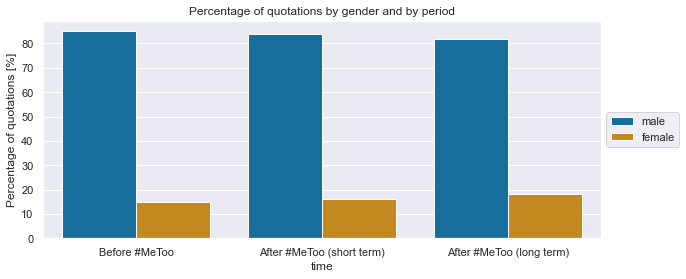

In [22]:
ax = sns.barplot(x = quotes_by_gender_periods['time'],
                 y = quotes_by_gender_periods['count']*100, hue = quotes_by_gender_periods['gender'], 
                 data = quotes_by_gender_periods)
ax.set(ylabel='Percentage of quotations [%]')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Percentage of quotations by gender and by period');

Again, we can see a slight increase in the percentage of female quotations: before the movement, the percentage was around 15%, and it is around 18% long after the movement.

## Number of occurences by gender from 2015 to 2020

In the previous part, we focused on the number of unique quotation per gender. We will now explore the total number of occurrences per gender to see if we observe any difference.

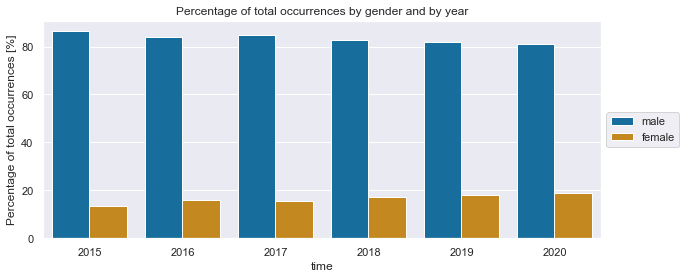

In [23]:
ax = sns.barplot(x = quotes_by_gender_years['time'], y = quotes_by_gender_years['Occurrences']*100,
                 hue = quotes_by_gender_years['gender'], data = quotes_by_gender_years)
ax.set(ylabel='Percentage of total occurrences [%]')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Percentage of total occurrences by gender and by year');

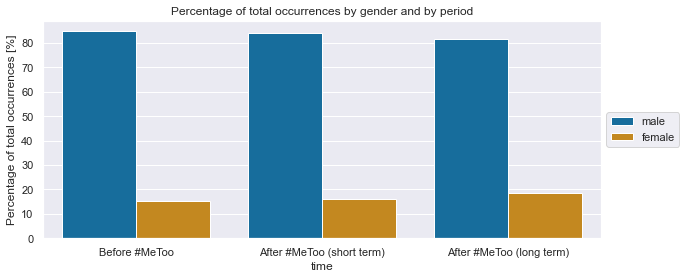

In [24]:
ax = sns.barplot(x = quotes_by_gender_periods['time'], 
                 y = quotes_by_gender_periods['Occurrences']*100, 
                 hue = quotes_by_gender_periods['gender'], data = quotes_by_gender_periods)
ax.set(ylabel='Percentage of total occurrences [%]')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Percentage of total occurrences by gender and by period');

We see that these graphs are essentially the same as the previous ones. Taking the number of unique quotations or the total number of occurrences by gender, we get the same proportions.

## Number of speakers by gender from 2015 to 2020

Previously, we examined the proportions of unique quotations by gender, as well as the proportion of total occurrences attributed to each gender. In this final section, let us examine the proportion of unique speakers of each gender over time.

In [25]:
by_speaker_years = []
for year, quotes in zip(years, quotes_years):
    by_speaker_years.append(unique_speaker_per_gender(quotes, year))

quotes_by_speaker_years = pd.concat(by_speaker_years, ignore_index = True)

In [26]:
quotes_by_speaker_years

,gender,count,time
0,male,0.829249,2015
1,female,0.170751,2015
2,male,0.821708,2016
3,female,0.178292,2016
4,male,0.810816,2017
5,female,0.189184,2017
6,male,0.808158,2018
7,female,0.191842,2018
8,male,0.801912,2019
9,female,0.198088,2019


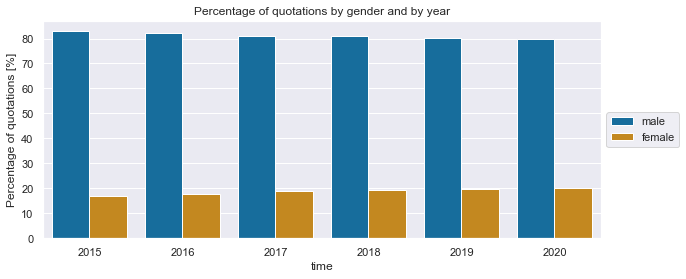

In [27]:
ax = sns.barplot(x = quotes_by_speaker_years['time'], y = quotes_by_speaker_years['count']*100,
                 hue = quotes_by_speaker_years['gender'], data = quotes_by_speaker_years)
ax.set(ylabel='Percentage of quotations [%]')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Percentage of quotations by gender and by year');

Again, we see that the proportion of male speakers is far greater than that of female speakers since they represent 80% of all speakers. However, in this graph, we observe a linear increase in female speakers over the years 2015 to 2020. In particular, in 2020, the proportion of female speakers reaches 20%. This is not the case when we look at the graph of occurences and quotations: it seems that a single male speaker has more quotations and occurences attributed to him than a female speaker.

In [28]:
by_speaker_periods = []
for period, quotes in zip(periods, quotes_years):
    by_speaker_periods.append(unique_speaker_per_gender(quotes, period))

quotes_by_speaker_periods = pd.concat(by_speaker_periods, ignore_index = True)

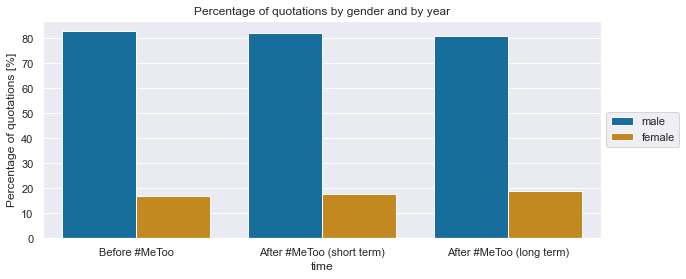

In [29]:
ax = sns.barplot(x = quotes_by_speaker_periods['time'], y = quotes_by_speaker_periods['count']*100, 
                 hue = quotes_by_speaker_periods['gender'], data = quotes_by_speaker_periods)
ax.set(ylabel='Percentage of quotations [%]')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Percentage of quotations by gender and by year');

Looking at this graph, we can see the same trend as above: there seem to be a few more female speakers than male speakers as time goes on. However, we don't know at this point if this is really related to the #MeToo movement or a general change in mindset.

## Lexical fields

Four different lexical fields are chosen and compared in the data. One is for "woman", another for "man" and the other two for "wife" and "husband". This study may give us a better understanding of the description and adjectives used to describe men and women in the newspapers.

In [30]:
chp_lex_woman = [' woman ', ' women ', ' girl ']
chp_lex_wife = [' wife ', ' girlfriend ']
chp_lex_man = [' man ', ' men ', ' boy ']
chp_lex_husband = [' husband ', ' boyfriend ']

Here a big dataframe is created gathering the data for all the years, with a new column "year", indicating the year.

The function $get\_champlex$ is applied for all years and the returned data frames are concatenated into a large data frame called "final_lexfield".

In [31]:
chplex2015 = get_champlex(quotes_all, int(2015), chp_lex_woman, chp_lex_man, chp_lex_wife, chp_lex_husband)
chplex2016 = get_champlex(quotes_all, 2016, chp_lex_woman, chp_lex_man, chp_lex_wife, chp_lex_husband)
chplex2017 = get_champlex(quotes_all, 2017, chp_lex_woman, chp_lex_man, chp_lex_wife, chp_lex_husband)
chplex2018 = get_champlex(quotes_all, 2018, chp_lex_woman, chp_lex_man, chp_lex_wife, chp_lex_husband)
chplex2019 = get_champlex(quotes_all, 2019, chp_lex_woman, chp_lex_man, chp_lex_wife, chp_lex_husband)
chplex2020 = get_champlex(quotes_all, 2020, chp_lex_woman, chp_lex_man, chp_lex_wife, chp_lex_husband)

final_lexfield = pd.concat([chplex2015,chplex2016,chplex2017,chplex2018,chplex2019,chplex2020],ignore_index = False)
final_lexfield.head(8)

,% of total quotations,% of total occurences,year
woman,0.752008,0.689666,2015.0
wife,0.150002,0.076901,2015.0
man,0.770008,0.646333,2015.0
husband,0.066001,0.121149,2015.0
woman,0.817008,0.974247,2016.0
wife,0.152002,0.115403,2016.0
man,0.806008,0.788831,2016.0
husband,0.073001,0.077133,2016.0


A barplot is presented showing the representation of each lexical field for each year.

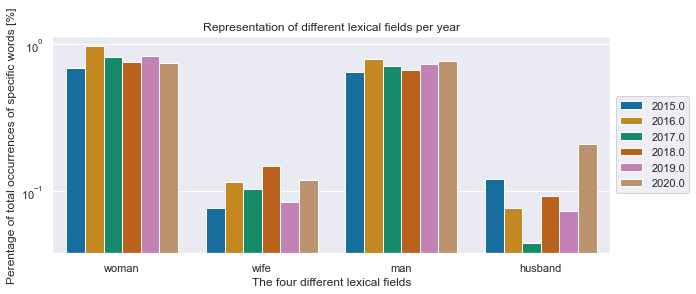

In [32]:
ax = sns.barplot(x =final_lexfield.index, y='% of total occurences',hue='year' ,data=final_lexfield)
plt.title('Representation of different lexical fields per year')
plt.xlabel('The four different lexical fields')
plt.ylabel('Perentage of total occurrences of specific words [%]')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(yscale="log");

## Age of the speakers

During the next section, the average ages of the speaker quoted in the journals will be represented and described.

In [33]:
#Read the basic statistic of the age of our dataset
quotes_all.describe()

,numOccurrences,age,year
count,699993.000000,699993.000000,699993.000000
mean,3.558053,52.380101,2017.428571
std,34.267873,27.449777,1.590791
min,1.000000,-6.000000,2015.000000
25%,1.000000,38.000000,2016.000000
50%,1.000000,52.000000,2017.000000
75%,2.000000,64.000000,2019.000000
max,25626.000000,2016.000000,2020.000000


We observe some abnormalities in the wikidata ages: someone is -6 years old, and another one is 2016 years old. Thus, we decide to keep only speakers born in the 20th century. These are also more relevant to our study.

In [34]:
#Removing age outliers
quotes_age = quotes_all.drop((quotes_all.loc[(quotes_all.age>110) | (quotes_all.age<10)]).index, inplace=False)

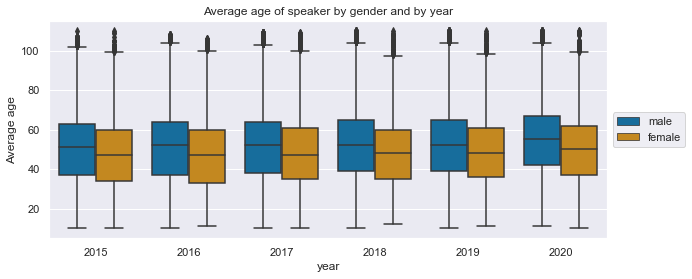

In [35]:
#Plot the distribution of age of the male and female speaker with respect to the year thanks to a boxlplot.
ax = sns.boxplot(x="year",y="age", hue="gender", 
            data=quotes_age.loc[quotes_age['gender'].isin(['male','female'])]);

ax.set(ylabel='Average age')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Average age of speaker by gender and by year');

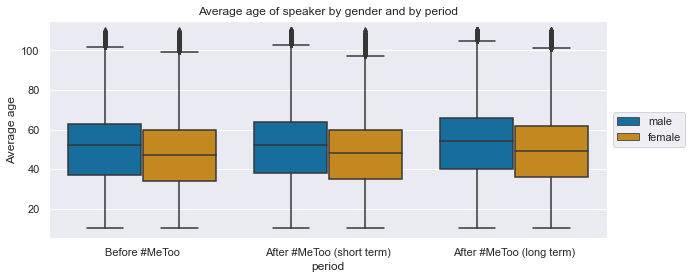

In [36]:
#For better vizualisation of the change that could have occured with the #MeToo movement, plot 
ax = sns.boxplot(x="period", y="age", hue="gender", 
           data=quotes_age.loc[quotes_age['gender'].isin(['male','female'])])

ax.set(ylabel='Average age')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Average age of speaker by gender and by period');

We observe no real significance between the years or the periods regarding the ages of the speakers. The average age with respect to the gender is quite constant over time. The difference lies only between the ages of the female speaker and the ages of the male speaker. Indeed, the female speakers are always younger in average, and quartiles by a few years then the male. This is however, not a significant difference.

## Main occupations represented

This next analysis is about getting to know  the occupations of the speakers in our dataset and understand the representation of both male and female occupation.

In [37]:
#Compute the 20 most represented occupations, regardless of gender.
df_occupation = quotes_all.get(['occupation','gender']).explode(ignore_index=True, column='occupation')
most_represented_occupation = df_occupation.merge(pd.DataFrame(Counter(df_occupation.occupation)\
                          .most_common(20),columns =['occupation','nb_occurences']), how='right', on='occupation')
most_represented_occupation

,occupation,gender,nb_occurences
0,politician,male,161742
1,politician,male,161742
2,politician,male,161742
3,politician,male,161742
4,politician,male,161742
...,...,...,...
762484,ice hockey player,male,17159
762485,ice hockey player,male,17159
762486,ice hockey player,female,17159
762487,ice hockey player,male,17159


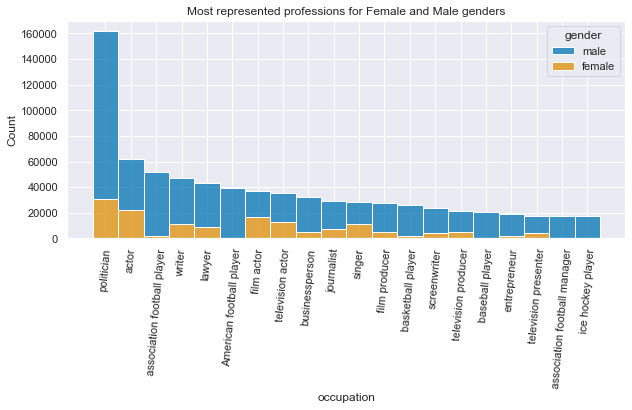

In [38]:
#Represent the 20 most represented occupations, distinguishing the share of men and women.
ax = sns.histplot(x="occupation", hue='gender', multiple="stack",
                 data=most_represented_occupation.loc[most_represented_occupation['gender'].isin(['male','female'])])
ax.set_title('Most represented professions for Female and Male genders')
plt.xticks(rotation=85);

In [39]:
df_occ_female=quotes_all[quotes_all['gender']=='female'].occupation.explode(ignore_index=True)
df_occ_male=quotes_all[quotes_all['gender']=='male'].occupation.explode(ignore_index=True)
print('There are', df_occ_female.shape[0], 'occupations listed for women and', df_occ_male.shape[0], 
      'occupations listed for men. This last one is', math.floor(df_occ_male.shape[0]/df_occ_female.shape[0]), 
      'times more than for women.')

There are 311193 occupations listed for women and 1254543 occupations listed for men. This last one is 4 times more than for women.


In [40]:
#Compute the 20 most reprensented occupations for female speakers
most_occ_female=pd.DataFrame(Counter(df_occ_female).most_common(20),columns =['occupation', 'nb_occurences'])
most_occ_female.head()

,occupation,nb_occurences
0,politician,30495
1,actor,22126
2,film actor,16484
3,television actor,12955
4,writer,11625


In [41]:
#Compute the 20 most reprensented occupations for male speakers
most_occ_male=pd.DataFrame(Counter(df_occ_male).most_common(20),columns =['occupation', 'nb_occurences'])
most_occ_male.head()

,occupation,nb_occurences
0,politician,131133
1,association football player,50483
2,actor,40157
3,American football player,39230
4,writer,35430


We next, plot these informations below.

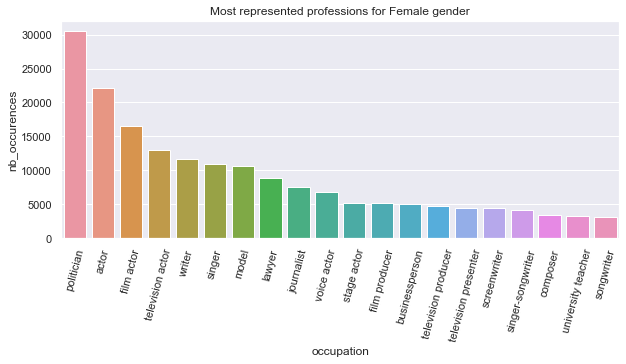

In [42]:
ax = sns.barplot(x='occupation', y='nb_occurences', data=most_occ_female)
ax.set_title('Most represented professions for Female gender')
plt.xticks(rotation=75);

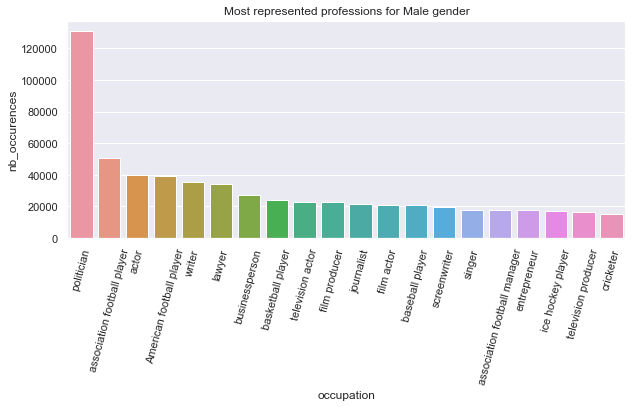

In [43]:
ax = sns.barplot(x='occupation', y='nb_occurences', data=most_occ_male)
ax.set_title('Most represented professions for Male gender')
plt.xticks(rotation=75);

These barplots show us that the most represented occupation for both men and women is politician: 131133 occurrences for men and 30495 for women. Moreover, the most cited occupations for male speakers are mainly in the sports categories (basketball, baseball, cricket, American soccer...), followed by business and arts. Women, on the other hand, are more present in artistic occupations (actor, television, writer, singer, composer...), then a little in the field of law and Business.

# #MeToo breatdh in the news

Since our project focus on the #MeToo movement, we would like to take a look at the movement coverage in the news. We will compare the proportions of quotations per year in which words from the #MeToo lexical field appear. We choose to focus on the words "MeToo", "Weinstein", "sexual harrassment", and "sexual assault".

In [44]:
list_sexual_harassment = []
lex_sexual_harassment = ['sexual harassment', 'sexual assault', 'rape', 'sexual touching']
list_metoo = []
lex_metoo = ['MeToo', 'metoo', 'meToo', 'Metoo', 'Weinstein']
for year, quotes in zip(years, quotes_years):
    df_metoo = quotes[quotes['quotation'].str.contains('|'.join(lex_metoo))]
    df_sexual_harassment = quotes[quotes['quotation'].str.contains('|'.join(lex_sexual_harassment))]
    list_metoo.append([len(df_metoo)*100000/len(quotes),year])
    list_sexual_harassment.append([len(df_sexual_harassment)*100000/len(quotes),year])

In [45]:
quotes_sexual_harassment = pd.DataFrame(list_sexual_harassment, columns = ['Nb of quotations about sexual harassment', 'year'])
quotes_metoo = pd.DataFrame(list_metoo, columns = ['Nb of quotations about #MeToo', 'year'])
quotes_metoo_harassment = quotes_sexual_harassment.merge(quotes_metoo)


In [46]:
quotes_metoo_harassment

,Nb of quotations about sexual harassment,year,Nb of quotations about #MeToo
0,108.190415,2015,0.000000
1,110.171868,2016,0.000000
2,158.186530,2017,43.187433
3,180.320971,2018,38.067761
4,149.279152,2019,21.039344
5,96.197204,2020,29.059572


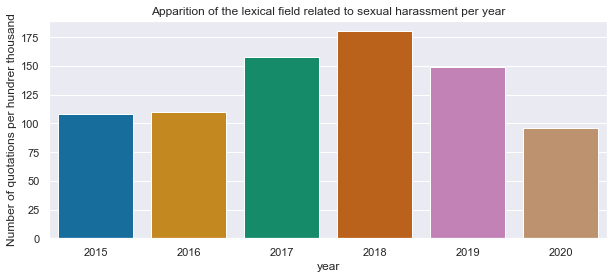

In [47]:
ax = sns.barplot(x = quotes_metoo_harassment['year'], y = quotes_metoo_harassment['Nb of quotations about sexual harassment'], data = quotes_metoo_harassment);
ax.set(ylabel='Number of quotations per hundrer thousand')
ax.set_title('Apparition of the lexical field related to sexual harassment per year');

We can see here that in 2015 and 2016, there were around 100 quotations for 100000 talking about sexual harassment. It rised in 2017, the year of the #MeToo movement, and continued to rise until 2018 were we report 175 quotations for 100000 talking about sexual harassment. However, after 2018, this number started to decrease and in 2020 we can see that we came back at 100 quotations for 100000, such as before the #MeToo movement.

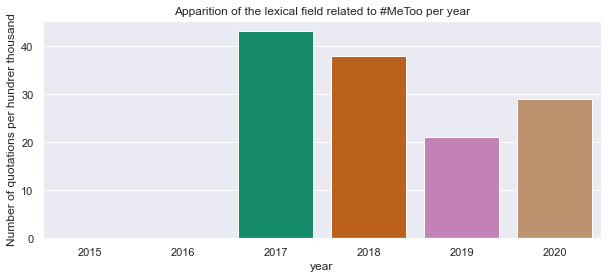

In [48]:
ax = sns.barplot(x = quotes_metoo_harassment['year'], y = quotes_metoo_harassment['Nb of quotations about #MeToo'], data = quotes_metoo_harassment);
ax.set(ylabel='Number of quotations per hundrer thousand')
ax.set_title('Apparition of the lexical field related to #MeToo per year');

As expected, there is no quotation about #MeToo before the movement in 2017. There is a rise at the time of the movement in 2017. However it represents only 40 quotations for 100000. We would have expected more, and it tells us that the coverage in the news was not as big as what we thought. The movement is still cited a few times per year, but not much.